# Miniproject-DQN Notebook
### Paul Boulenger, Paul Devianne

##### Note : some functions and classes defined for a question may be reused later for other questions

## Part 1: Introduction


In [22]:
#We import all necessary packages
import sys

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

""" Importing usueful packages"""
from tqdm import tqdm
import random
from collections import namedtuple, deque
import copy
from statistics import median
from matplotlib.ticker import MultipleLocator

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Functions and classes definition (used all over the project)

In [11]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action

def run_episode(agent : Agent, env : Env, seed = 0 ) : #runs a 30 week episode, of a given environment and with a given agent

    log = []
    rwds = []
    finished = False
    obs, info = env.reset(seed)
    while not finished:
        action = agent.act(obs)
        obs, rwd, finished, info = env.step(action)
        log.append(info)
        rwds.append(rwd.item())

    return log, rwds

def plot_episode(log, dyn, plot_actions = False) : 
   
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters[:-1]} #we don't plot the total pop
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters[:-1]} for c in dyn.cities}
    

    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    #total full state plot
    [ax_leftstate.plot(y) for y in total.values()] 
    ax_leftstate.legend([rf'${k[0]}_{{total}}^{{[w]}}$' for k in total.keys()]) 
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    #total observable state plot
    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend([rf'${y}_{{total}}^{{[w]}}$' for y in ['i','d']])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    
    #cities observable state plots
    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time $w$ (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))
    ax_right['Lausanne'].legend([rf'${y}_{{city}}^{{[w]}}$' for y in ['i','d']])

    if plot_actions :
        actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=3)
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel(rf'time $w$ (in weeks)')

    fig.tight_layout()
    plt.show()

def extract_episode_features(log, rwds):
        
        N_confinement = 7 * sum([l.action['confinement'] for l in log])
        cumulative_rwd = sum(rwds)
        N_deaths = log[-1].total.dead
        
        return [N_confinement, cumulative_rwd, N_deaths]

def hist_avg(ax, data,title):
        ymax = 50
        if title == 'deaths':
            x_range = (1000,200000)
        elif title == 'cumulative rewards': 
            x_range = (-300,300)
        elif 'days' in title:
            x_range = (0,200)
        else:
            raise ValueError(f'{title} is not a valid title') 
        ax.set_title(title)
        ax.set_ylim(0,ymax)
        ax.vlines([np.mean(data)],0,ymax,color='red')
        ax.hist(data,bins=60,range=x_range)      
        
def plot_episodes_features(episodes_features):

    
    N_confinements = np.array(episodes_features['conf_days'])
    cumulative_rewards = np.array(episodes_features['cumulative_rwd'])
    N_deaths = np.array(episodes_features['deaths'])
    
    fig, ax = plt.subplots(3,1,figsize=(10,10))        

    hist_avg(ax[0], N_confinements,'confinement days')
    hist_avg(ax[1], cumulative_rewards,'cumulative rewards')
    hist_avg(ax[2], N_deaths,'deaths')
    fig.tight_layout()
    plt.show()

    """ Print example """
    print(f'Average death number: {np.mean(N_deaths)}')
    print(f'Average number of confined days: {np.mean(N_confinements)}')
    print(f'Average cumulative reward: {np.mean(cumulative_rewards)}')

def eval_procedure(agent, env):
    
    seed_sequence = np.arange(0,50)
    episodes_features = {"conf_days": [], "cumulative_rwd": [], "deaths": []}
    for i in tqdm(seed_sequence):    
        log, rwds = run_episode(agent, env, i)
        episode_feature = extract_episode_features(log, rwds)
        for j, key in enumerate(episodes_features.keys()):
            episodes_features[key].append(episode_feature[j])
    
    return episodes_features

def extract_all_episode_features(log, rwds):
        
        N_confinement = 7 * sum([l.action['confinement'] for l in log])
        N_isolation = 7 * sum([l.action['isolation'] for l in log])
        N_vaccination = 7 * sum([l.action['vaccination'] for l in log])
        N_hospital = 7 * sum([l.action['hospital'] for l in log])
        cumulative_rwd = sum(rwds)
        N_deaths = log[-1].total.dead
        
        return [N_confinement,  N_isolation,  N_vaccination, N_hospital, N_deaths, cumulative_rwd]

def all_eval_procedure(agent, env):
    seed_sequence = np.arange(0,50)
    episodes_features = {"N_confinement": [],  "N_isolation": [],  "N_vaccination": [], "N_hospital": [], "N_deaths": [], "cumulative_rwd": []}
    for i in tqdm(seed_sequence):    
        log, rwds = run_episode(agent, env, i)
        episode_feature = extract_episode_features(log, rwds)
        for j, key in enumerate(episodes_features.keys()):
            episodes_features[key].append(episode_feature[j])
    
    return episodes_features

def get_average_episode_feature(episodes_features):
     return [np.mean(np.array(episodes_features[key])) for key in episodes_features.keys()]

### Question 1.a

##### Functions and classes definition

In [12]:
class NoAgent(Agent): #the agent which take no action
    def __init__(self,  env:Env):
        self.env = env
        
    def load_model(self, savepath): pass

    def save_model(self, savepath): pass

    def optimize_model(self): return 0
    
    def reset(self,): pass
    
    def act(self, obs):
        return 0

##### Running

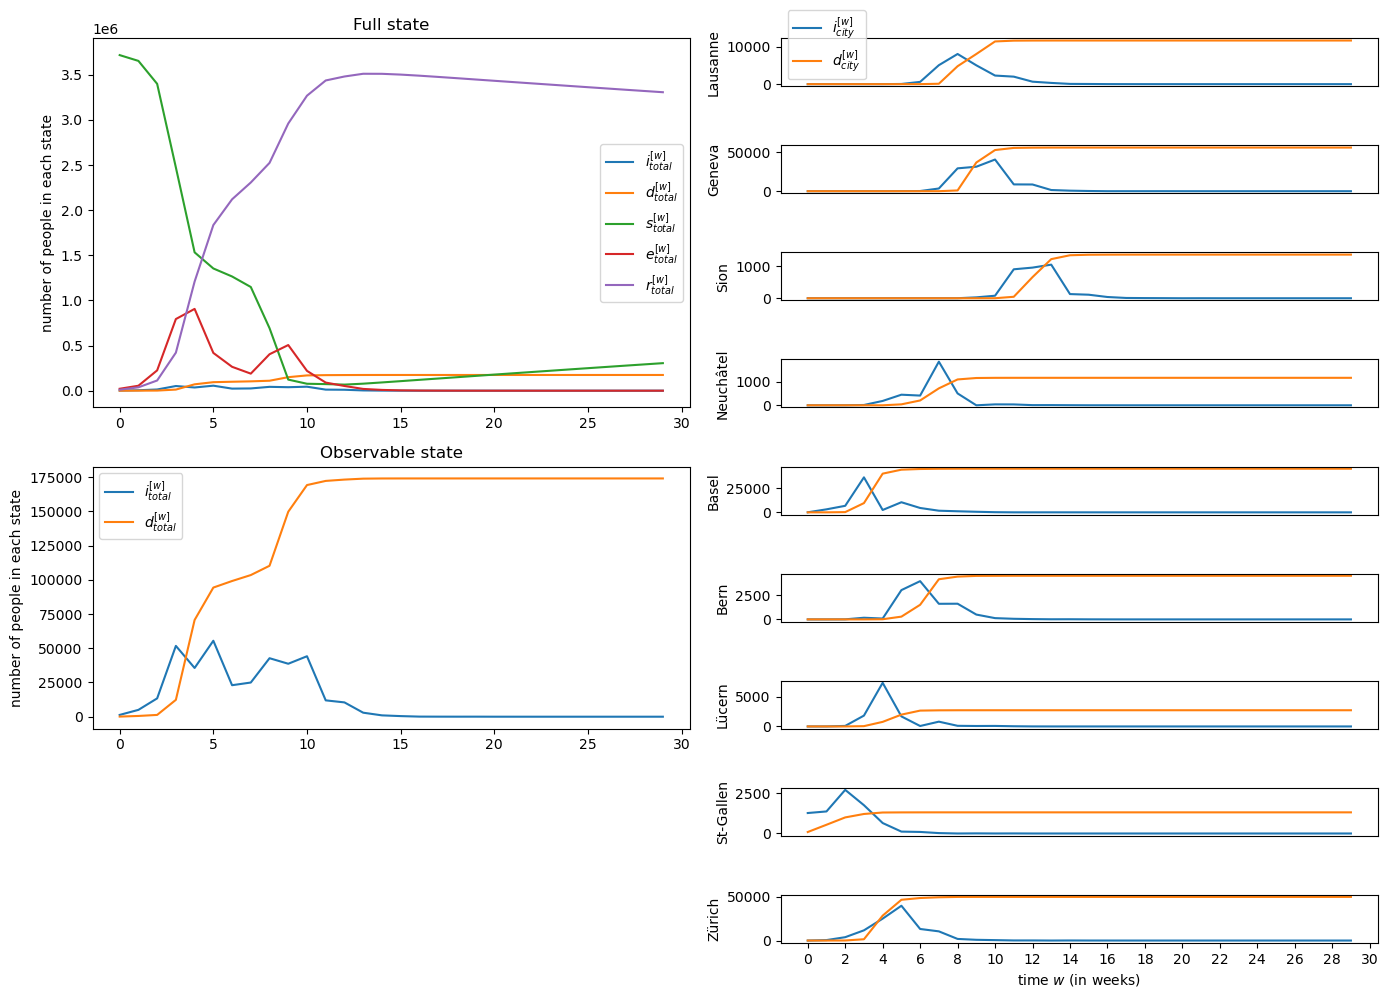

In [13]:
dyn = ModelDynamics('config/switzerland.yaml')
env = Env(dyn,
            action_preprocessor=action_preprocessor)

no_agent = NoAgent(env) #Agent that takes no action

log , _ = run_episode(no_agent, env)

plot_episode(log, dyn)

## Part 2: Professor Russo's Policy

### Question 2.a — Implement Pr. Russo’s Policy


##### Functions and classes definition

In [15]:
class RussoAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                max_infected:int=2e4, # maximum number of infected people before confinement
                confinement_period:int= 4, # confinement period in weeks
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.time_confined = 0
        self.population_infection_limit = max_infected
        self.confinement_period = confinement_period
                
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self):
        # This should be called when the environment is reset
        self.time_confined = 0
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        confined = (self.time_confined < self.confinement_period) and (self.time_confined > 0)   
        if confined:
            self.time_confined += 1
            return 1
          
        elif obs > self.population_infection_limit:
            self.time_confined = 1
            return 1
        
        self.time_confined = 0
        return 0

In [16]:
def observation_preprocessor_Russo(obs: Observation, dyn:ModelDynamics):
    infected=np.array(
        [np.array(obs.city[c].infected) for c in dyn.cities])[:,6].sum() #only need to observe the number of infected
    return infected

##### Running

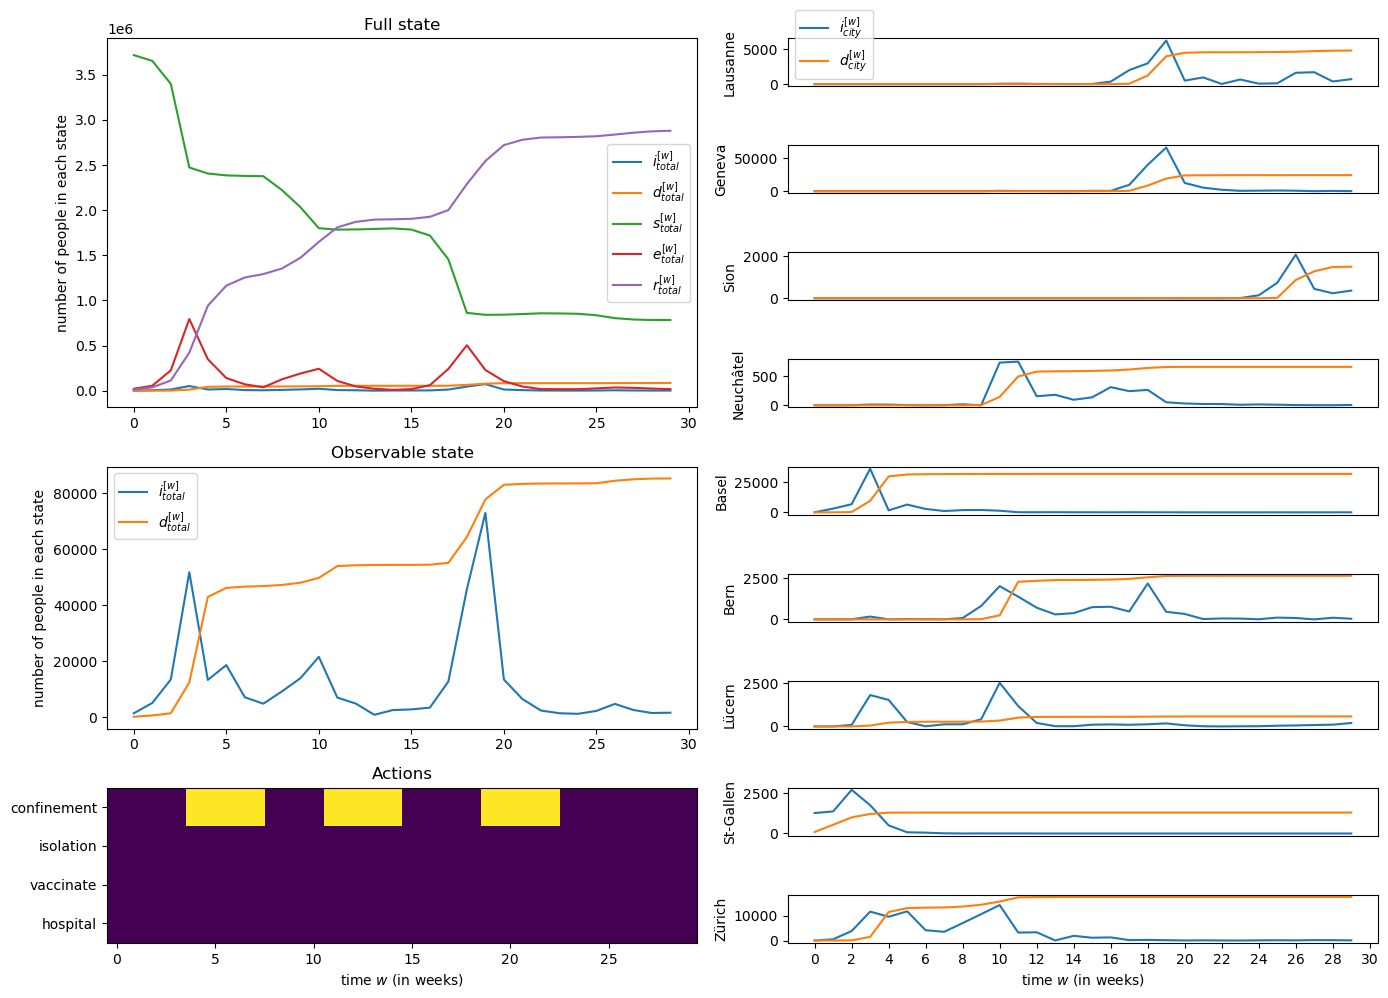

[84, -136.98130042105913, 85243]


In [17]:
dyn = ModelDynamics('config/switzerland.yaml')
russo_env = Env(dyn,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_Russo)
obs, info = russo_env.reset(0)
russo_agent = RussoAgent(env)
log, rwds = run_episode(russo_agent, russo_env)
plot_episode(log, dyn, True)
print(extract_episode_features(log, rwds))

The professor's policy correctly confines population whenever the total population of infected is above 20'000 at the beginning of a week. The confinement are indeed four weeks long and the population is released when the total population of infected is below 20'000 at the end of the confinement. 

More specifically, three confinements are done in total. In comparison with the unmittigated case, the professor's policy reduces the total number of deaths by almost 100'000 people or 55 %. Then, we clearly the positive effect of the confinement rule on the epidemic development.

### Question 2.b — Evaluate Pr. Russo’s Policy

The seed sequence we will use is ranging from 0 to 49 changing from each episode to another. We will then average the results over the 50 episodes.

100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


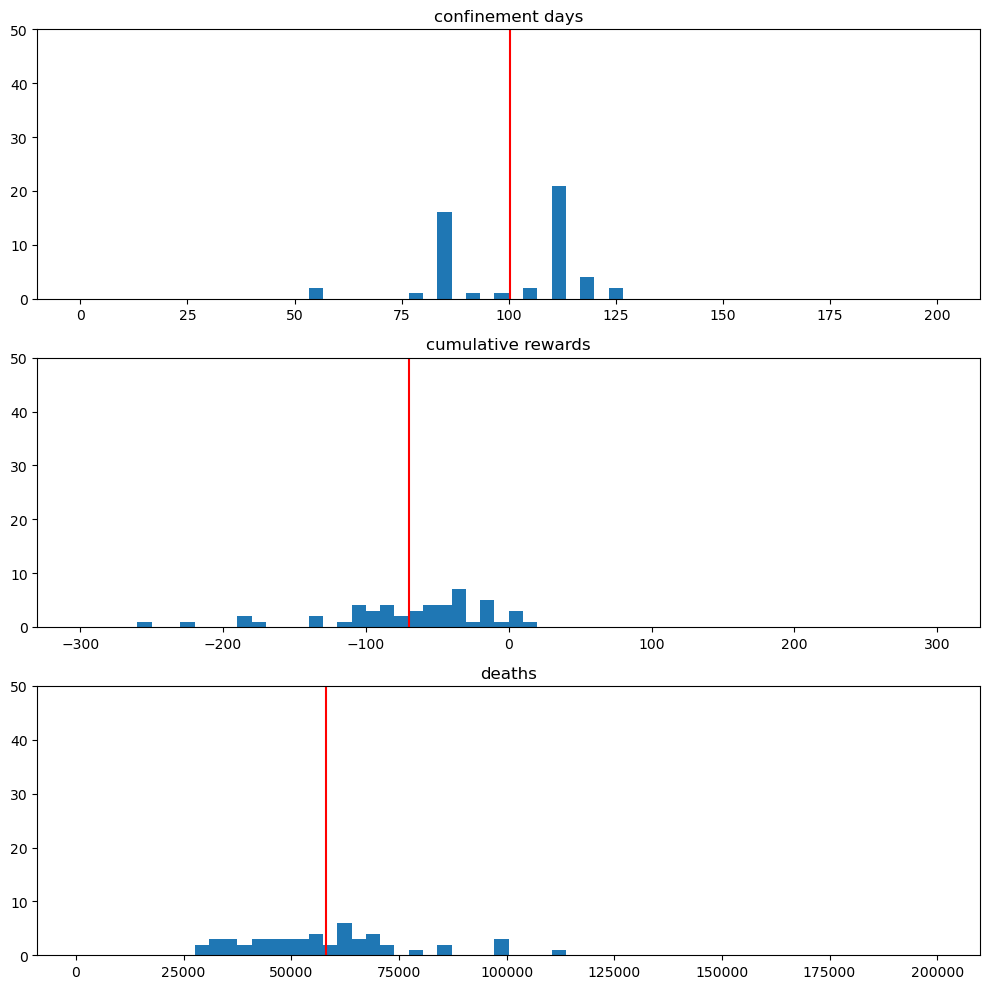

Average death number: 58071.94
Average number of confined days: 100.24
Average cumulative reward: -69.96264824778075


In [18]:
russo_env = Env(dyn,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_Russo)
russo_agent = RussoAgent(env)

episodes_features = eval_procedure(russo_agent, russo_env)

plot_episodes_features(episodes_features)

## Part 3: A Deep Q-learning approach


#### Question 3.a

##### Functions and classes definition

In [24]:
SCALE = 100

class DQN(nn.Module): #Q network as shown in the Pytorch example

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.n_observations = n_observations 
        self.hidden_layer1 = nn.Linear(n_observations, 64)
        self.hidden_layer2 = nn.Linear(64, 32)
        self.hidden_layer3 = nn.Linear(32, 16)
        self.out_layer = nn.Linear(16, n_actions)

    def forward(self, x):
        #x has shape[batchsize, obs_space, 9 , 7]
        x = x.view(-1,self.n_observations) #shape [batchsize,n_observations]
        x = F.relu(self.hidden_layer1(x)) #shape [batchsize, 64]
        x = F.relu(self.hidden_layer2(x)) #shape [batchsize, 32]
        x = F.relu(self.hidden_layer3(x)) #shape [batchsize, 16]
        return self.out_layer(x) #output [batchsize, n_actions]

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


def observation_preprocessor_DQN(obs: Observation, dyn:ModelDynamics):
    infected = (SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]))**(1/4)
    dead = (SCALE* np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]))**(1/4)
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQNAgent(Agent) :
    def __init__(self,  env: Env ,lr = 5e-3, C =5, BATCH_SIZE = 2480, BUFFER_SIZE = 20000, eps_0 = 0.7, gamma = 0.9 ,eps_min = None , Tmax = 500):
        self.BATCH_SIZE = BATCH_SIZE
        self.BUFFER_SIZE = BUFFER_SIZE
        self.GAMMA = gamma
        self.env = env
        self.t = 0 #time t
        self.C = C
        if eps_min != None : 
            self.eps_decay = True
            self.eps_0 = eps_0
            self.eps_min = eps_min
            self.Tmax = Tmax
            
        else : 
            self.eps_decay = False
            self.eps = eps_0

        self.n_actions = env.action_space.n
        self.n_observations = np.prod(env.observation_space.shape)
        self.policy_net = DQN(self.n_observations,self.n_actions)
        self.target_net = DQN(self.n_observations, self.n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.memory =  ReplayMemory(self.BUFFER_SIZE)

    def get_eps(self): 
        if self.eps_decay : return max(self.eps_0*(self.Tmax - self.t)/self.Tmax,self.eps_min)
        else : return self.eps

    def load_model(self, savepath:str):
        
        weights = torch.load(savepath)
        self.policy_net.load_state_dict(weights)
        self.target_net.load_state_dict(weights)
        
        
    def save_model(self, savepath:str):
       
        torch.save(self.policy_net.state_dict(), savepath + '.pth')

    def optimize_model(self):
        
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE) #List[(obs, action, reward, next_state)]
        
        batch = Transition(*zip(*transitions))

        next_state_batch = torch.cat(batch.next_state)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_Qvalues = self.policy_net(state_batch).gather(1, action_batch) #shape[batch_size, 1]

        with torch.no_grad():
            next_state_Qvalues = self.target_net(next_state_batch).max(1)[0]
        
        # Compute the expected Q values
        expected_state_action_Qvalues = (next_state_Qvalues * self.GAMMA) + reward_batch.squeeze()

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_Qvalues.squeeze(), expected_state_action_Qvalues)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        #torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1000)
        self.optimizer.step()

        if self.t%self.C == 0 :
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.t += 1


    
    def reset():
        """Resets the agent's inner state
        """

    def add_memory(self, state, action, next_state, reward) :
        self.memory.push(state, action, next_state, reward)

    def act(self, obs:torch.Tensor, eps_0 = True):
        if eps_0 : eps = 0 #no exploration
        else : eps = self.get_eps()
        
        sample = torch.rand(1)

        if sample <= 1 - eps:
            with torch.no_grad():
                Q_vals  = self.policy_net(obs)
            return Q_vals.max(1)[1].view(1,1)
        else :
            return torch.tensor([[self.env.action_space.sample()]], dtype=torch.long)

def training_step(last_obs,env, agent)  :
    action = agent.act(last_obs, False)
    obs, rwd, finished, info = env.step(action)#.item())

    agent.add_memory(last_obs, action, obs, rwd)

    agent.optimize_model()

    return obs, rwd.item(), finished, info  

def training_episode(env, agent, seed) :
    log = []
    rwds = []
    obs, info = env.reset(seed)
    finished = False
    while not finished:
        obs, rwd, finished, info = training_step(obs, env, agent)
        log.append(info)
        rwds.append(rwd)

    return log, rwds

def training_loop(env, agent, first_seed, savepath : str ,Tmax = 500) :
    
    training_trace = []
    eval_trace  = []
    eval_env = copy.deepcopy(env)

    random.seed(first_seed * 100) 
    torch.manual_seed(first_seed * 100)
    torch.use_deterministic_algorithms(True)

    for i in tqdm(range(Tmax)):
        _, rwds = training_episode(env, agent, seed = first_seed + i)
        training_trace.append(np.array(rwds).sum())
        if i%50 == 0 or i == Tmax : 
            cumul_rwds = []
            for j in range(20) :
                _ ,rwds = run_episode(agent,eval_env, j)
                cumul_rwds.append(np.array(rwds).sum())
            
            avg_rwd = np.array(cumul_rwds).mean()

            if i == 0 : 
                agent.save_model(savepath)
            elif eval_trace[-1] < avg_rwd : agent.save_model(savepath) #we save only if the model is better
        
            eval_trace.append(avg_rwd)
        
    return training_trace, eval_trace

def moving_median(data, window_size):
    medians = []
    for i in range(window_size, len(data) - window_size + 1):
        window = data[i-window_size:i+window_size]
        med = median(window)
        medians.append(med)
    return medians

def plot_training(training_traces, eval_traces,window_size = 30):
    colors = ['red', 'blue', 'green'] 
    x = list(range(len(training_traces[0]))) 
    _, ax = plt.subplots()

    for i, training_trace in enumerate(training_traces):
            y = training_trace 
            ax.scatter(x, y, color=colors[i], label=f'Training {i+1}')

    ax.legend() 
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Rewards')
    plt.show()
    moving_medians = [moving_median(training_trace, window_size) for training_trace in training_traces]

    _, ax = plt.subplots()
    x = list(range(window_size, len(x)- window_size + 1)) 
    for i, moving_med in enumerate(moving_medians):
            y = moving_med
            ax.plot(x,y, color=colors[i], label=f'Training {i+1}')

    ax.legend() 
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Rewards')
    plt.show()

    x = list(range(0,500,50))
    avg_eval_trace = np.mean(np.array(eval_traces), axis=0)
    plt.plot(x,avg_eval_trace)
    plt.xlabel('Training steps')
    plt.ylabel('Average evaluation rewards')
    plt.show()
    return


##### Training

In [37]:
binary_action_space=spaces.Discrete(2)
dyn = ModelDynamics('config/switzerland.yaml')
DQNobservation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


DQNenv = Env(dyn,
            action_space = binary_action_space,
            observation_space= DQNobservation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

DQNagents = [DQNAgent(DQNenv) for _ in range(3)] #three agents
training_traces = []
eval_traces = []

In [38]:
for i,DQNag in enumerate(DQNagents) : #three training processes
    training_trace, eval_trace  = training_loop(DQNenv, DQNag, savepath= f"models/DQNparam{i+1}" ,first_seed= (i+1)*1000)
    training_traces.append(training_trace)
    eval_traces.append(eval_trace)


100%|██████████| 500/500 [15:35<00:00,  1.87s/it]


##### Plotting

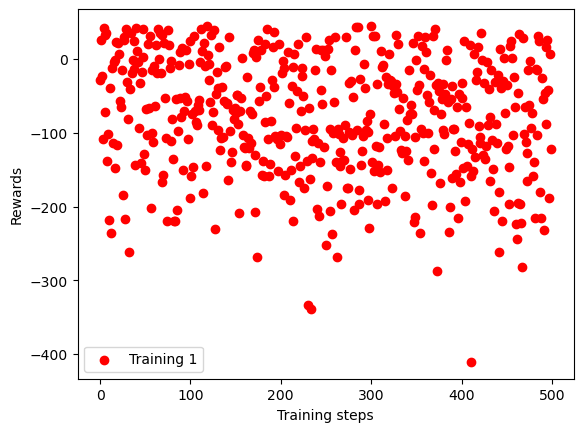

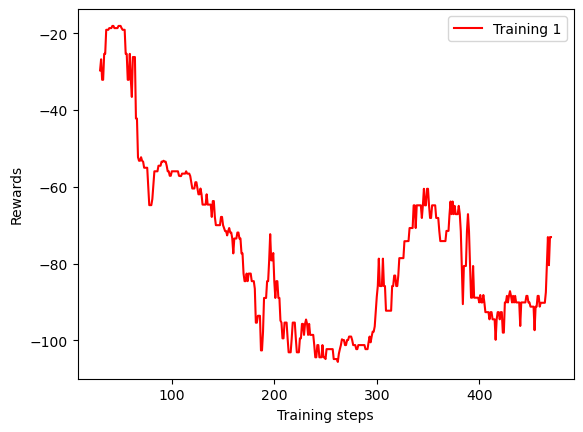

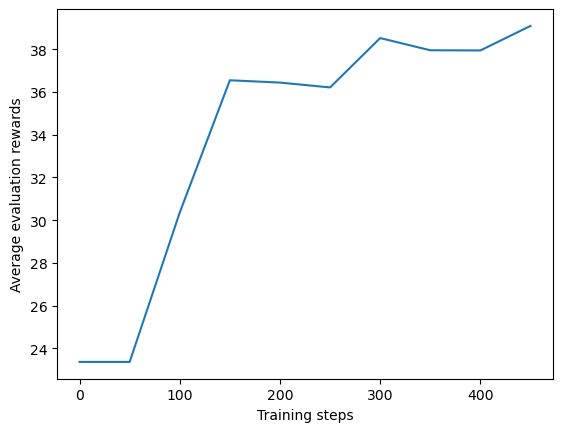

In [39]:
plot_training(training_traces, eval_traces)

##### Looking at the policy

In [40]:
best_evals = np.max(eval_traces, 1)
best_agent_idx = np.argmax(best_evals)
print(f"The best is agent {best_agent_idx +1}")

The best is agent 1


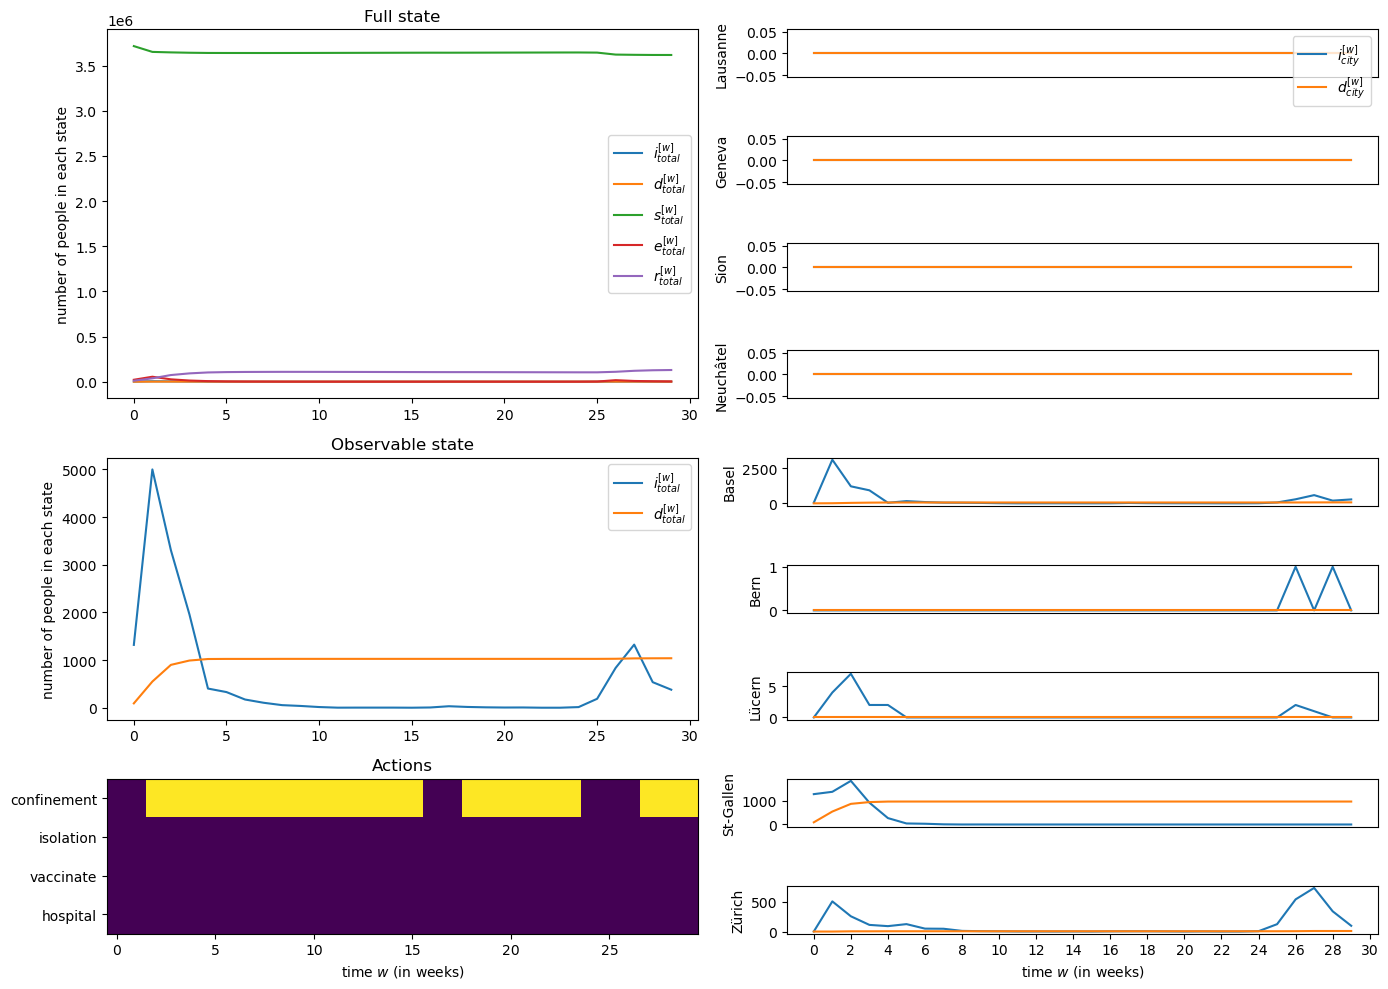

In [41]:
best_DQNagent = DQNAgent(DQNenv) #only for eval
best_DQNagent.load_model("models/DQNparam1.pth")

three_episodes = [run_episode(best_DQNagent, DQNenv, 100*i) for i in range(3)]
plot_episode(three_episodes[0][0], dyn, True)

#### Question 3.b

##### Training

In [35]:
binary_action_space=spaces.Discrete(2)
dyn = ModelDynamics('config/switzerland.yaml')
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

DQNenv = Env(dyn,
            action_space = binary_action_space,
            observation_space= observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

DQNdecay_agents = [DQNAgent(DQNenv, eps_min= 0.2) for _ in range(3)] #three agents with eps decay
decay_training_traces = []
decay_eval_traces = []

In [ ]:
for i,DQNag in enumerate(DQNdecay_agents) : #three training processes
    training_trace, eval_trace  = training_loop(DQNenv, DQNag, savepath= f"models/DQNdecay_param{i+1}" ,first_seed= (i+1)*1000)
    decay_training_traces.append(training_trace)
    decay_eval_traces.append(eval_trace)

##### Plotting

In [18]:
plot_training(decay_training_traces, decay_eval_traces)

IndexError: list index out of range

#### Question 3.c 

In [19]:
DQNenv = Env(dyn,
            action_space = binary_action_space,
            observation_space= DQNobservation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

best_DQNagent = DQNAgent(DQNenv, eps_0=0.0) #only for eval
best_DQNagent.load_model("models/DQNparam1.pth")

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


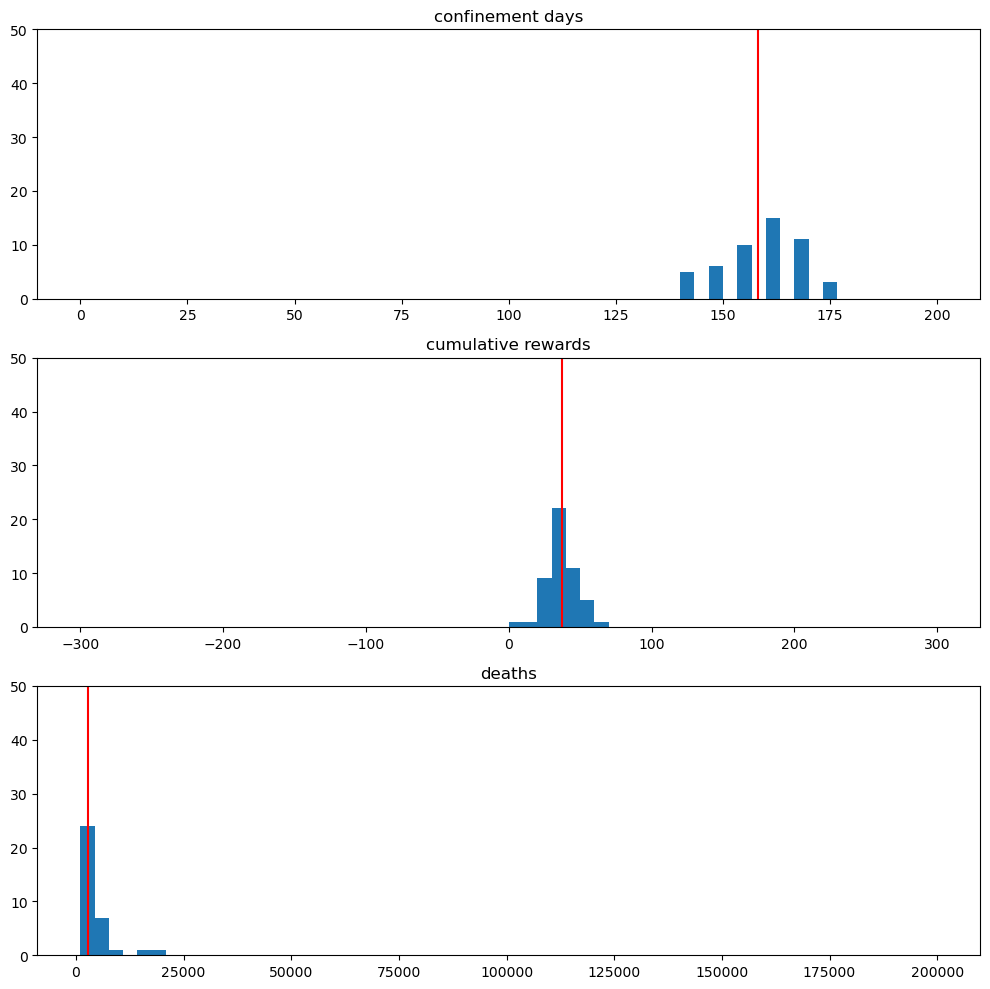

Average death number: 2706.56
Average number of confined days: 158.2
Average cumulative reward: 37.17053986826912


In [20]:
episode_features = eval_procedure(best_DQNagent,DQNenv)
plot_episodes_features(episode_features)

Comparing with the professor's policy, we see that our best DQN policy is more efficient in reducing the number of deaths. Indeed, the DQN policy reduces the number of deaths by 55'000 people in average compared to the professor's policy case, it represents a reduction of 95% in average which is remarkable. A part from this we have a positive average reward of 37 while the professor's policy had an average reward of -69. The DQN policy is then more efficient in reducing the number of deaths and in keeping the economy running. The only drawback is the increased number of confined days which is higher in the DQN policy case. 

## Part4: Dealing with a more complex action Space

### Question 4.1 Toggle-action-space multi-action agent

#### Question 4.1.a
The action-observation space is now representing the change to the system we want to make. It is not about how the agent intervene in the system. It is how the agent wants to change rules in the system. The Q-value is now a 1D boolean array of size 5.

In a dynamical environment like this one, the optimal action changes over time. The agent has to adapt to the environment. Instead of having fixed actions with specific changes, the toggle action space is more flexible and allows higher maneuverability of the system.

However, this affects the network architecture which takes a more complex input. The input now also includes the state of the actions in addition to the state of the system. This implies that the network must be designed to accommodate these more complex preprocessors, which require additional layers and modifications to handle the augmented input.

Training with the action-observation space introduces a new challenge in learning the Q-values. The Q-values of toggle actions are dependent on the current state of each action, which means they can change dynamically during training. This introduces additional complexity in estimating accurate Q-values. The agent needs to learn not only the optimal Q-value for a given action but also how the state of that action affects its Q-value. This can lead to a more challenging training process, requiring longer training times and potentially more complex algorithms to converge to optimal policies.

#### Question 4.1.b

##### Functions and classes definition

In [42]:
toggle_action_space = action_space=spaces.Discrete(5)

SCALE = 100

def toggle_observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])**(1/4)
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])**(1/4)
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    isolated = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    beds_added = np.ones_like(dead)*int((dyn.get_action()['hospital']))
    vaccinated = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))
    return torch.Tensor(np.stack((infected, dead, confined, isolated, beds_added,vaccinated))).unsqueeze(0)

def toggle_action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action()

    if a == ACTION_CONFINE:
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
    elif a == ACTION_HOSPITAL:
        action['hospital'] = not action['hospital']
        
    return action


toggle_observation_space = spaces.Box( low=0,
                                    high=1,
                                    shape=(6, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

##### Training

In [43]:
toggle_env = Env(dyn,
            action_space = toggle_action_space,
            observation_space= toggle_observation_space,
            action_preprocessor= toggle_action_preprocessor,
            observation_preprocessor= toggle_observation_preprocessor)

DQNtoggle_agents = [DQNAgent(toggle_env, eps_min= 0.2, lr = 1.0e-3) for _ in range(3)] #three toggle agents with eps decay
toggle_training_traces = []
toggle_eval_traces = []


In [ ]:
for i,DQNag in enumerate(DQNtoggle_agents) : #three training processes
    training_trace, eval_trace  = training_loop(toggle_env, DQNag, savepath= f"models/DQNtoggle_param{i+1}" ,first_seed= (i+1)*1000)
    toggle_training_traces.append(training_trace)
    toggle_eval_traces.append(eval_trace)

##### Plotting

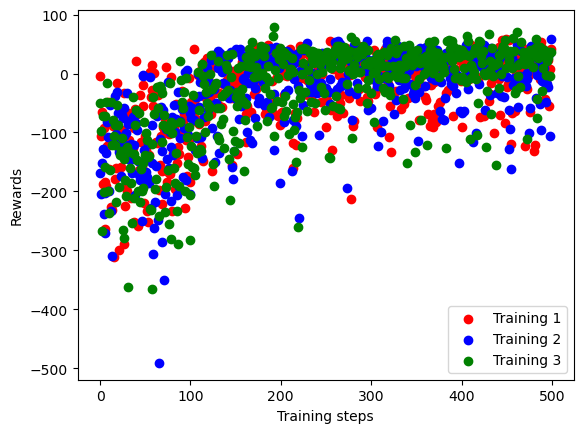

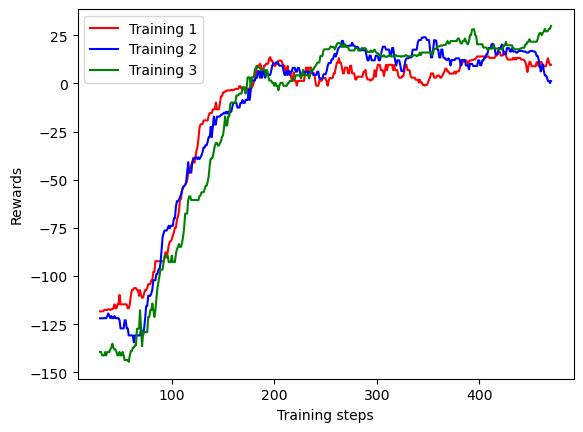

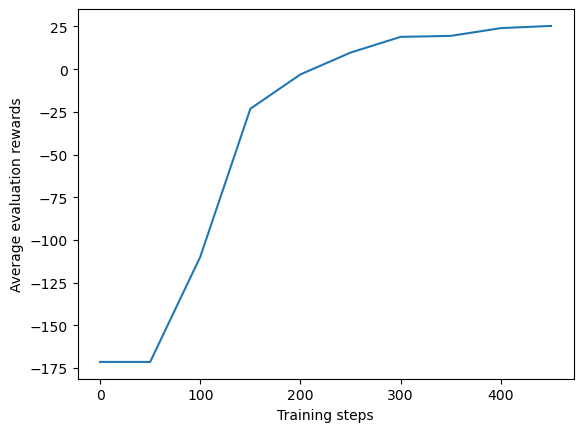

In [ ]:
plot_training(toggle_training_traces, toggle_eval_traces)

##### Looking at the policy

In [22]:
toggle_best_evals = np.max(toggle_eval_traces, 1)
toggle_best_agent_idx = np.argmax(best_evals)
print(f"The best is agent {best_agent_idx +1}")

AxisError: axis 1 is out of bounds for array of dimension 1

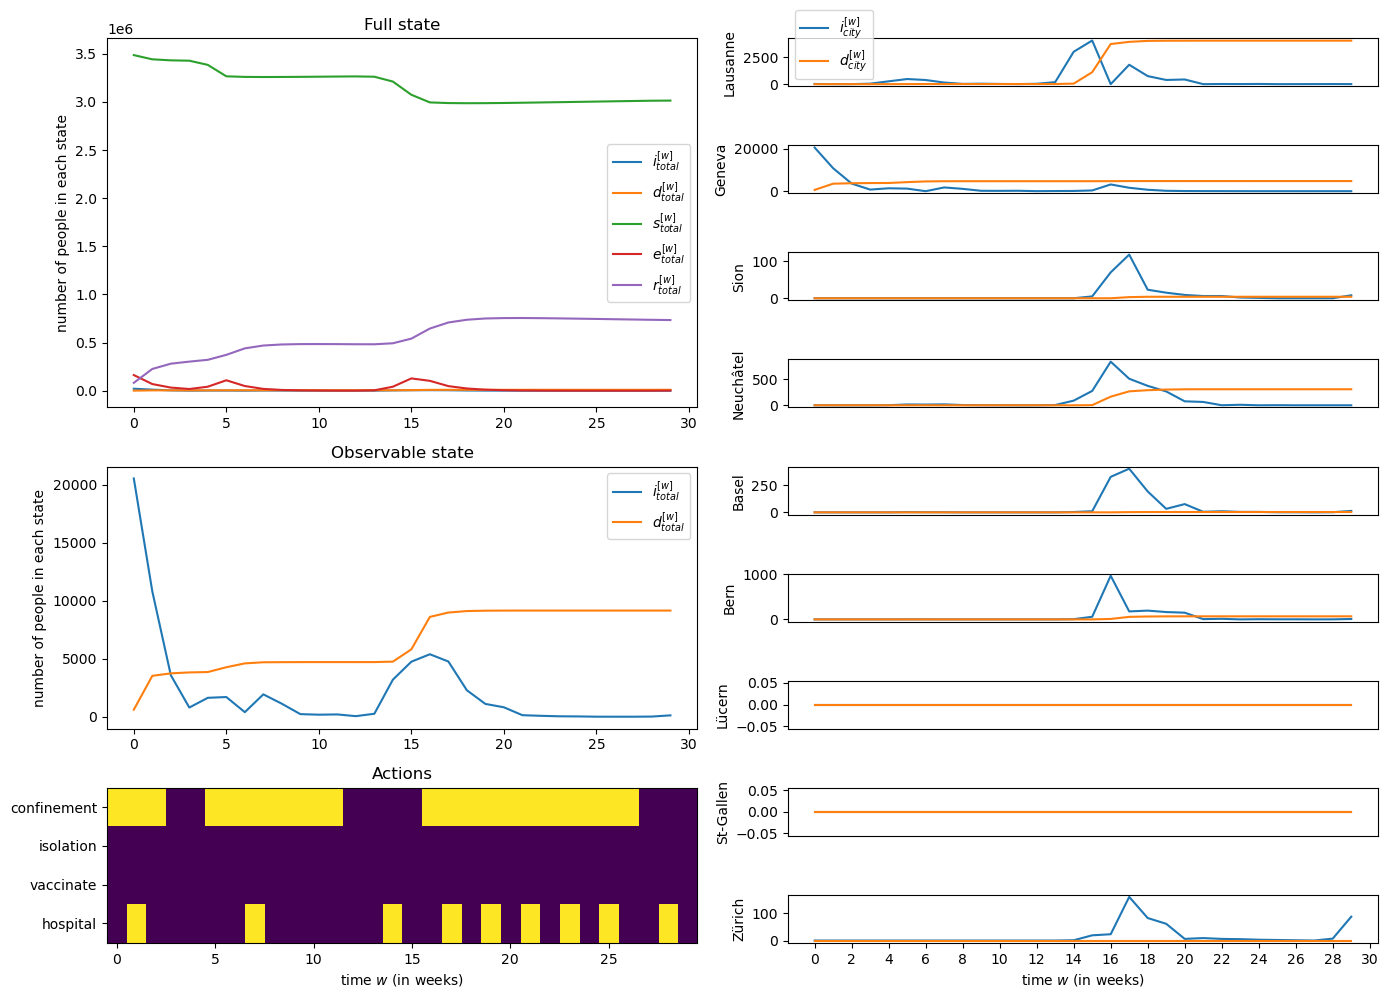

In [23]:
best_DQNtoggle_agent = DQNAgent(toggle_env) ###only for eval
best_DQNtoggle_agent.load_model("models/DQNtoggle_param1.pth")

three_episodes = [run_episode(best_DQNtoggle_agent, toggle_env, 100*i) for i in range(3)]
plot_episode(three_episodes[1][0], dyn, True)

#### Question 4.1.c

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


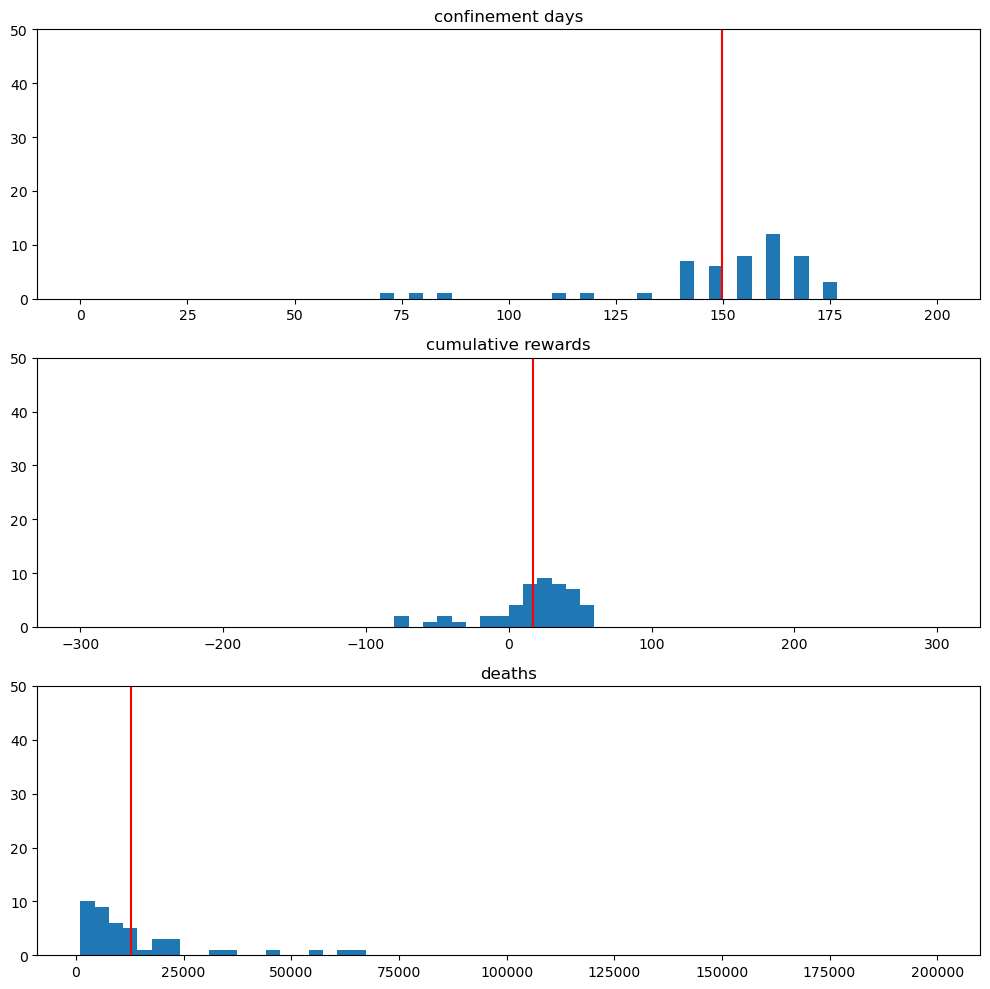

Average death number: 12656.34
Average number of confined days: 149.8
Average cumulative reward: 16.660592730583158


In [24]:
toggle_env = Env(dyn,
            action_space = toggle_action_space,
            observation_space= toggle_observation_space,
            action_preprocessor= toggle_action_preprocessor,
            observation_preprocessor= toggle_observation_preprocessor)

best_DQNtoggle_agent = DQNAgent(toggle_env, eps_0= 0.0) ###only for eval
best_DQNtoggle_agent.load_model("models/DQNtoggle_param1.pth")

DQNtoggle_episodes_features = eval_procedure(best_DQNtoggle_agent, toggle_env)

plot_episodes_features(DQNtoggle_episodes_features)

#### Question 4.1.d
The assumption made in the toggle action space is the fact that the actions are binary, or with a fixed number to the least. However, actions with continuous values would not be fitted for the toggle space. For instance, one could vaccinate people from a certain age range which would not be possible with the toggle action space because it would add a very high number of possible actions for all possible age ranges. More complex continuous type of actions could be thought of, but the general idea is that transforming it into a binary action would not be possible.

### 4.2 Factorized Q-values, multi-action agent

#### Question 4.2.a

##### Functions and classes definition

In [52]:
class DQN_factorized(nn.Module): #Q network as shown in the Pytorch example

    def __init__(self, n_observations, n_actions):
        super(DQN_factorized, self).__init__()
        self.n_observations = n_observations 
        self.hidden_layer1 = nn.Linear(n_observations, 64)
        self.hidden_layer2 = nn.Linear(64, 32)
        self.hidden_layer3 = nn.Linear(32, 16)
        self.out_layer = nn.Linear(16, n_actions*2)

    def forward(self, x):
        #x has shape[batchsize, obs_space, 9 , 7]
        x = x.view(-1,self.n_observations) #shape [batchsize,n_observations]
        x = F.relu(self.hidden_layer1(x)) #shape [batchsize, 64]
        x = F.relu(self.hidden_layer2(x)) #shape [batchsize, 32]
        x = F.relu(self.hidden_layer3(x)) #shape [batchsize, 16]
        return self.out_layer(x) #output [batchsize, 8]

def DQN_observation_preprocessor_factorized(obs: Observation, dyn:ModelDynamics):
    return observation_preprocessor_DQN(obs, dyn)

def DQN_action_preprocessor_factorized(a:torch.Tensor, dyn:ModelDynamics):
    action = {
        'confinement': bool(a[0]),
        'isolation': bool(a[1]),
        'hospital': bool(a[2]),
        'vaccinate': bool(a[3]),
    }
    
    return action

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN_factorizedAgent(Agent) :
    def __init__(self,  env: Env ,lr = 5e-3, C =5, BATCH_SIZE = 2048, BUFFER_SIZE = 20000, eps_0 = 0.7, gamma = 0.9 ,eps_min = None , Tmax = 500):
        self.BATCH_SIZE = BATCH_SIZE
        self.BUFFER_SIZE = BUFFER_SIZE
        self.GAMMA = gamma
        self.env = env
        self.t = 0 #time t
        self.C = C

        if eps_min != None : 
            self.eps_decay = True
            self.eps_0 = eps_0
            self.eps_min = eps_min
            self.Tmax = Tmax
            
        else : 
            self.eps_decay = False
            self.eps = eps_0

        self.n_actions = env.action_space.n
        self.n_observations = np.prod(env.observation_space.shape)
        self.policy_net = DQN_factorized(self.n_observations,self.n_actions)
        self.target_net = DQN_factorized(self.n_observations, self.n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.memory =  ReplayMemory(self.BUFFER_SIZE)

    def get_eps(self): 
        if self.eps_decay : return max(self.eps_0*(self.Tmax - self.t)/self.Tmax,self.eps_min)
        else : return self.eps

    def load_model(self, savepath:str):
        
        weights = torch.load(savepath)
        self.policy_net.load_state_dict(weights)
        self.target_net.load_state_dict(weights)
        
    def save_model(self, savepath:str):
       
        torch.save(self.policy_net.state_dict(), savepath + '.pth')

    def optimize_model(self):
        
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE) #List[(obs, action, reward, next_state)]
        
        batch = Transition(*zip(*transitions))

        next_state_batch = torch.cat(batch.next_state)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action).reshape(-1,4,1)
        reward_batch = torch.cat(batch.reward)
        state_action_Qvalues = self.policy_net(state_batch)
        saQfs = state_action_Qvalues[:, :4]
        saQts = state_action_Qvalues[:,4:]

        state_action_Qvalues = torch.stack([saQfs, saQts], dim=2).gather(2,action_batch).squeeze()
        state_action_Qvalues = torch.sum(state_action_Qvalues, dim=1, keepdim=True)
        
        with torch.no_grad():
            next_state_Qvalues = self.target_net(next_state_batch)
        nsQfs = next_state_Qvalues[:, :4]
        nsQts = next_state_Qvalues[:,4:]
        next_state_Qvalues = torch.max(torch.stack([nsQfs, nsQts], dim=2), dim=2)[0]
        next_state_Qvalues = torch.sum(next_state_Qvalues, dim=1, keepdim=True)
        
        # Compute the expected Q values
        expected_state_action_Qvalues = (next_state_Qvalues * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_Qvalues, expected_state_action_Qvalues)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        #torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1000)
        self.optimizer.step()

        if self.t%self.C == 0 :
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.t += 1

    
    def reset():
        """Resets the agent's inner state
        """

    def add_memory(self, state, action, next_state, reward) :
        self.memory.push(state, action, next_state, reward)

    def act(self, obs:torch.Tensor, eps_0 = True):
        if eps_0 : eps = 0 #no exploration
        else : eps = self.get_eps()
        
        sample = torch.rand(1)

        if sample <= 1 - eps:
            with torch.no_grad():
                Q_vals = self.policy_net(obs) #shape[1,8]
            # Split the Q-values tensor into halves
            split_size = Q_vals.size(1) // 2
            Qfs, Qts  = torch.split(Q_vals, split_size, dim=1) #(false tensor shape[1,4], true tensor shape[1,4] )
            # Choose the action for each decision independently
            action_batch = torch.argmax(torch.cat((Qfs, Qts), dim=0), dim=0)
        else:
            # Randomly sample each decision independently
            action_batch = torch.tensor(np.array([self.env.action_space.sample() for _ in range(obs.size(0))]), dtype=torch.long)
        
        return action_batch.squeeze()

factorized_action_space = spaces.MultiBinary(4)

factorized_observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

##### Training

In [53]:
dyn = ModelDynamics('config/switzerland.yaml')

factorized_env = Env(dyn,
            action_space = factorized_action_space,
            observation_space= factorized_observation_space,
            action_preprocessor=DQN_action_preprocessor_factorized,
            observation_preprocessor=DQN_observation_preprocessor_factorized)

DQNfactorized_agents = [DQN_factorizedAgent(factorized_env, eps_min= 0.2, lr=7.0e-5) for _ in range(3)] #three agents with eps decay
factorized_training_traces = []
factorized_eval_traces = []

In [54]:
for i,DQNag in enumerate(DQNfactorized_agents) : #three training processes
    training_trace, eval_trace  = training_loop(factorized_env, DQNag, savepath= f"models/DQNfactorized_param{i+1}" ,first_seed= (i+1)*1000, Tmax=500)
    factorized_training_traces.append(training_trace)
    factorized_eval_traces.append(eval_trace)

  0%|          | 0/500 [00:06<?, ?it/s]


KeyboardInterrupt: 

##### Plotting

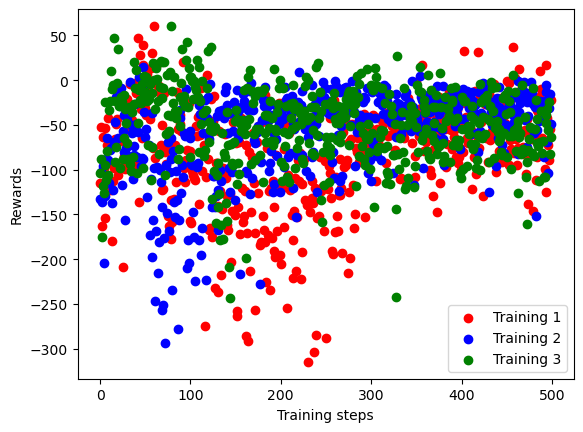

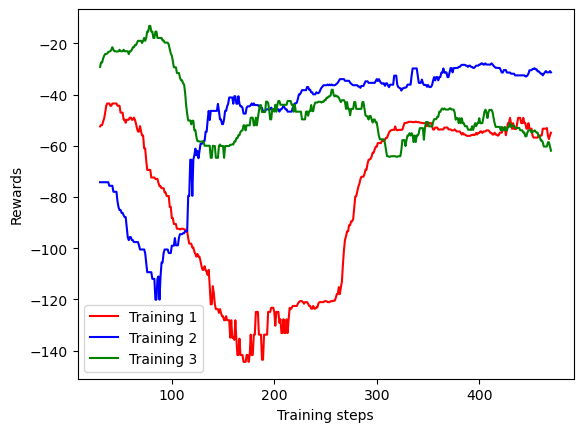

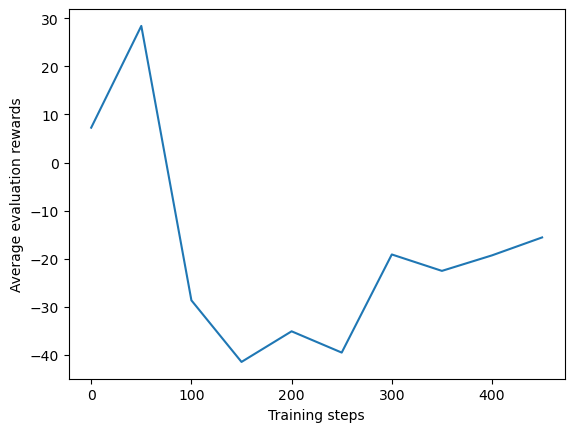

In [38]:
plot_training(factorized_training_traces, factorized_eval_traces)

##### Looking at the policy

In [39]:
factorized_best_evals = np.max(factorized_eval_traces, 1)
factorized_best_agent_idx = np.argmax(factorized_best_evals)
print(f"The best is agent {factorized_best_agent_idx +1}")

NameError: name 'factorized_eval_traces' is not defined

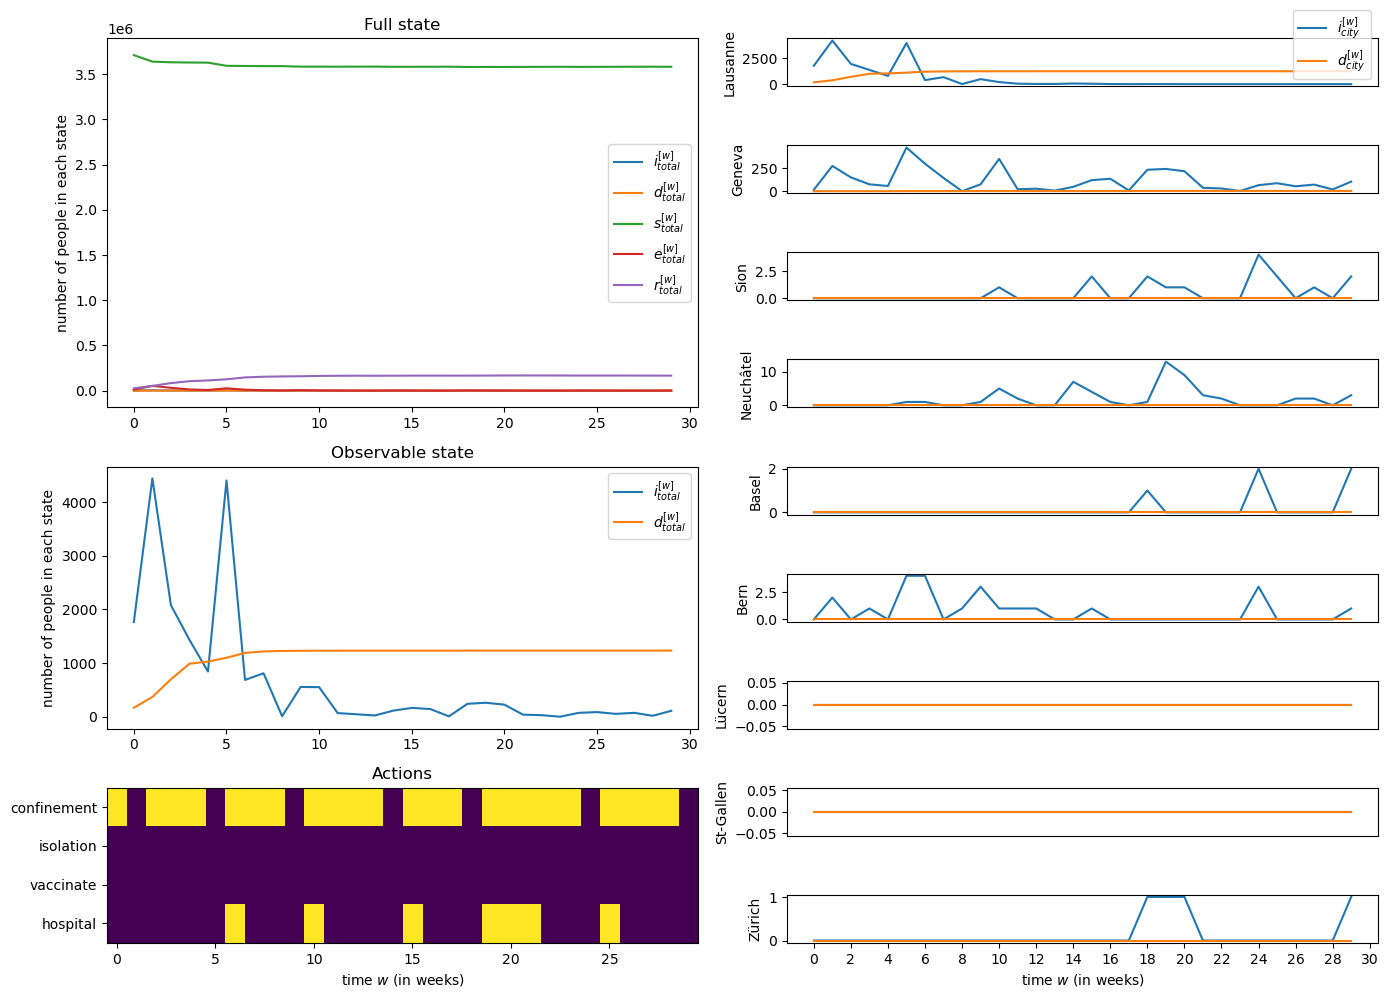

In [61]:
best_DQNfactorized_agent = DQN_factorizedAgent(factorized_env) ###only for eval
best_DQNfactorized_agent.load_model("models/DQNfactorized_param1.pth")

three_episodes = [run_episode(best_DQNfactorized_agent, factorized_env, 100*i) for i in range(3)]
plot_episode(three_episodes[2][0], dyn, True)

#### Question 4.2.b

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


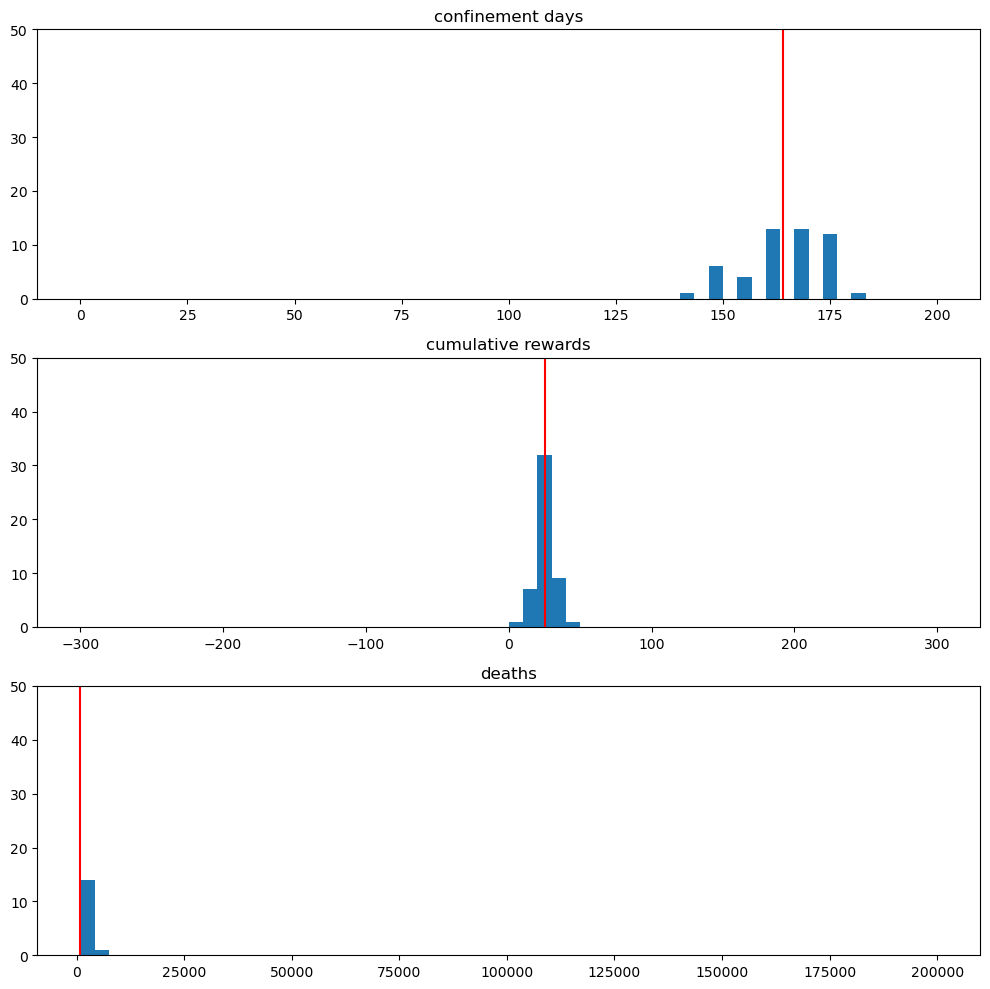

Average death number: 867.82
Average number of confined days: 163.94
Average cumulative reward: 25.120161666045895


In [58]:
factorized_env = Env(dyn,
            action_space = factorized_action_space,
            observation_space= factorized_observation_space,
            action_preprocessor= DQN_action_preprocessor_factorized,
            observation_preprocessor= DQN_observation_preprocessor_factorized)

best_DQNfactorized_agent = DQN_factorizedAgent(factorized_env, eps_0= 0.0) ###only for eval
best_DQNfactorized_agent.load_model("models/DQNfactorized_param1.pth")

DQNfactorized_episodes_features = eval_procedure(best_DQNfactorized_agent, factorized_env)

plot_episodes_features(DQNfactorized_episodes_features)

## Part5: Wrapping Up

#### Question 5.a

#### Question 5.b

#### Question 5.c